<a href="https://colab.research.google.com/github/BaichooSiddharth/Devoir_1_Data_Science/blob/master/Devoir_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#on fait les imports
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

#les couleurs pour pouvoir plot les points
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [ ]:
#on lit et on stock les valeurs qu'une fois dans cette cellule car putain sa mère c'est chiant de reload ça à chaque fois
train_MNIST = np.genfromtxt('mnist_train.csv', delimiter=',')
test_MNIST = np.genfromtxt('mnist_test.csv', delimiter=',')

In [ ]:
#On enlève la première rangée qui décrit chaque colonne. On a les labels qui sont à gauche du jeu de données (1ère colonne) 
# et les valeurs sont toutes les colonnes après autour.
train_MNIST_relevant = train_MNIST[1:, :]
test_MNIST_relevant = test_MNIST[1:, :]

train_MNIST_relevant_points = train_MNIST_relevant[:, 1:]
train_MNIST_relevant_labels = train_MNIST_relevant[:, 0]


In [ ]:
def groupByClassMNIST(dataset):
    #on regroupe tous les points d'une classe en utilisant cette fonction en des dictionaires
    labels = dataset[:, 0]
    labels_unique = np.unique(labels)
    dictio = dict()
    for label in  labels_unique:
        points = dataset[np.where(dataset[:,0] == label)]
        dictio[label] = points
    return dictio

# **Partition binaire**

# **K-medoïde**

# **PCoA**

In [ ]:
class PCoA:
    def __init__(self, similarity, n_components, n_init, max_iterations):
        self.similarity = similarity
        self.n_components = n_components
        self.n_init = n_init
        self.max_iterations = max_iterations
        self.classifier = manifold.MDS(n_components = self.n_components, n_init = self.n_init, max_iter = self.max_iterations, dissimilarity = "precomputed")
        
    def partition(self, x_train, y_train):
        if(self.similarity):
            similarity_matrix = cosine_similarity(x_train)
            dissimilarity_matrix = 1 - similarity_matrix 
#on prend 1- la similarité car PCoA ne prend que les dissimilarités Sinon ce serait PCA ce qui n'est pas demandé dans la question. Aussi cela fait du sens 
#car la dissimilarité est inversement proportionelle à la similarité et la valeur varie de 0 à 1 donc on prend 1-la solution obtenue)           
        else:
            dissimilarity_matrix = euclidean_distances(x_train)
            
        nouveaux_points = self.classifier.fit_transform(dissimilarity_matrix)
        num_points = y_train.shape[0]
        final_array = np.zeros((num_points,(self.n_components + 1)))
        final_array[:, 1:] = nouveaux_points
        final_array[:, 0] = y_train
        return final_array
        

def plot_points_MNIST(dict_new_points):
    for i,j in enumerate(dict_new_points):
        spec_class = dict_new_points[j]
        x_axis = spec_class[:, 1]
        y_axis = spec_class[:, 2]
        plt.plot(x_axis, y_axis, colors[i], marker = 'o', linestyle = 'None', label = j)
        
    plt.legend(loc='best')   
    plt.show
    
        

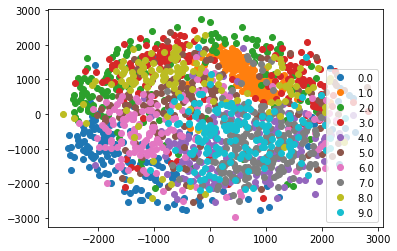

In [ ]:
pcoa = PCoA(False, 2, 4, 1600)

projected_points = pcoa.partition(train_MNIST_relevant_points[0:1500], train_MNIST_relevant_labels[0:1500])

pcoa_grouped_points = groupByClassMNIST(projected_points)

plot_points_MNIST(pcoa_grouped_points)


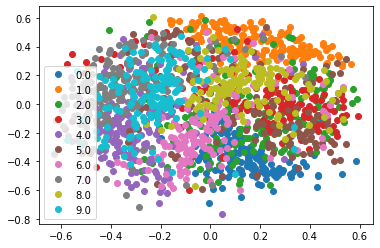

In [ ]:
pcoa_similarity = PCoA(True, 2, 4, 1600)

projected_points_similarity = pcoa_similarity.partition(train_MNIST_relevant_points[0:1500], train_MNIST_relevant_labels[0:1500])

pcoa_grouped_points_similarity = groupByClassMNIST(projected_points_similarity)

plot_points_MNIST(pcoa_grouped_points_similarity)



# **Isomap**

# **KNN**